# VQE Demo

VQE demo with pennylane.

## VQE demo with molecular data

In [33]:
import matplotlib.pyplot as plt
import pennylane as qml
import torch

from pennylane import numpy as np

In [46]:
# Setup hamiltonian.
# Will explore a H2 molecule.

# Specify molecule data
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])

molecule = qml.qchem.Molecule(symbols, coordinates)
molecule

<Molecule = H2, Charge: 0, Basis: STO-3G, Orbitals: 2, Electrons: 2>

In [47]:
# Construct the hamiltonian

H, qubits = qml.qchem.molecular_hamiltonian(molecule)
print(f"Number of qubits: {qubits}")
print(f"Hamiltonian: {H}") # Is a series of Pauli gates.

Number of qubits: 4
Hamiltonian: -0.042072551947440084 * I(0) + 0.1777135822909176 * Z(0) + -0.24274501260941383 * Z(2) + 0.12293330449299354 * (Z(0) @ Z(2)) + 0.1777135822909176 * Z(1) + 0.17059759276836806 * (Z(0) @ Z(1)) + 0.04475008406301996 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04475008406301996 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04475008406301996 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04475008406301996 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.24274501260941383 * Z(3) + 0.1676833885560135 * (Z(0) @ Z(3)) + 0.12293330449299354 * (Z(1) @ Z(3)) + 0.1676833885560135 * (Z(1) @ Z(2)) + 0.17627661394181787 * (Z(2) @ Z(3))


In [48]:
# Setup device
dev = qml.device("default.qubit", wires=qubits)
dev

<default.qubit device (wires=4) at 0x1c6356f6410>

In [49]:
# Lets prepare the quantum circuit ansatz.
# We will prepare a quantum state with a 4 qubit Jordan Wigner representation
# with two states, one with both electrons in the ground state, and one with the
# electrons both in excited state.
# We can setup a hartree fock state which will be our starting point of the 
# vqe. We will use the hf state to form our quantum register.
electrons = molecule.n_electrons
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [50]:
# Circuit ansatz.
@qml.qnode(dev, interface="torch")
def circuit(param, quantum_register, num_wires):
    qml.BasisState(quantum_register, wires=range(num_wires))
    qml.DoubleExcitation(param, wires=range(num_wires))
    return qml.expval(H)

# Cost function is simply the expectation value.
def cost_fn(param, hartree_fock_state, qubits):
    return circuit(param, hartree_fock_state, num_wires=qubits)

Parameter containing:
tensor([0.0327], requires_grad=True) 



c:\Users\Hoawen\AppData\Local\Programs\Python\Python310\lib\site-packages\pennylane\math\utils.py:228: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
C:\Users\Hoawen\AppData\Local\Temp\ipykernel_12608\4136451194.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


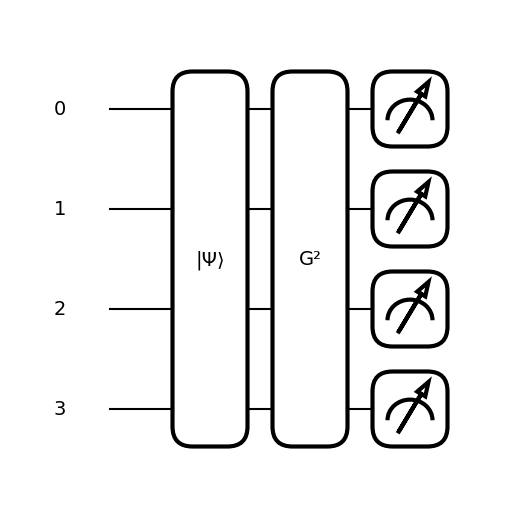

In [113]:
# Initialise container to store results
results = {"theta_param":[], 
           "energy_expectation_value":[]}

# Intialise theta parameter.
theta_value = torch.randn(1, requires_grad=True) * 0.1
theta_param = torch.nn.Parameter(theta_value)
print(theta_param, "\n")

# Draw circuit
fig, ax = qml.draw_mpl(circuit)(theta_param, hf, qubits)
plt.tight_layout()
plt.show()

# Initialise optimiser
opt = torch.optim.Adam([theta_param], lr=0.1)

In [114]:
# Training loop
epochs = 40
for i in range(epochs):
    # Ensure gradients are zero
    opt.zero_grad()

    # Run both the forward pass and calculate the cost function.
    # Remember cost function is the expectation value.
    loss = cost_fn(theta_param, hf, qubits)
    
    # Backpropagate.
    loss.backward()
    
    # Update parameters.
    opt.step()

    parameter_value = theta_param.clone().detach().numpy()

    results["theta_param"].append(parameter_value)
    results["energy_expectation_value"].append(loss.detach().numpy())

    print(f"Epoch {i + 1}: Loss = {loss.item():.8f} Ha, Theta = {theta_param.detach().numpy()}")

print(f"Final parameters: {theta_param}")
print(f"Final cost: {cost_fn(theta_param, hf, qubits).item():.4f}")

c:\Users\Hoawen\AppData\Local\Programs\Python\Python310\lib\site-packages\pennylane\math\utils.py:228: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch 1: Loss = -1.12275879 Ha, Theta = [0.13274734]
Epoch 2: Loss = -1.13364264 Ha, Theta = [0.22394595]
Epoch 3: Loss = -1.13610233 Ha, Theta = [0.28953326]
Epoch 4: Loss = -1.13345316 Ha, Theta = [0.31692043]
Epoch 5: Loss = -1.13125488 Ha, Theta = [0.31257167]
Epoch 6: Loss = -1.13164688 Ha, Theta = [0.28815663]
Epoch 7: Loss = -1.13354670 Ha, Theta = [0.2529183]
Epoch 8: Loss = -1.13538761 Ha, Theta = [0.21433686]
Epoch 9: Loss = -1.13618000 Ha, Theta = [0.17925923]
Epoch 10: Loss = -1.13578992 Ha, Theta = [0.1535793]
Epoch 11: Loss = -1.13483407 Ha, Theta = [0.14079273]
Epoch 12: Loss = -1.13414684 Ha, Theta = [0.14123997]
Epoch 13: Loss = -1.13417329 Ha, Theta = [0.15286328]
Epoch 14: Loss = -1.13479920 Ha, Theta = [0.17236479]
Epoch 15: Loss = -1.13558896 Ha, Theta = [0.19590536]
Epoch 16: Loss = -1.13610698 Ha, Theta = [0.21946092]
Epoch 17: Loss = -1.13614848 Ha, Theta = [0.23923069]
Epoch 18: Loss = -1.13581511 Ha, Theta = [0.25225514]
Epoch 19: Loss = -1.13541194 Ha, Theta 

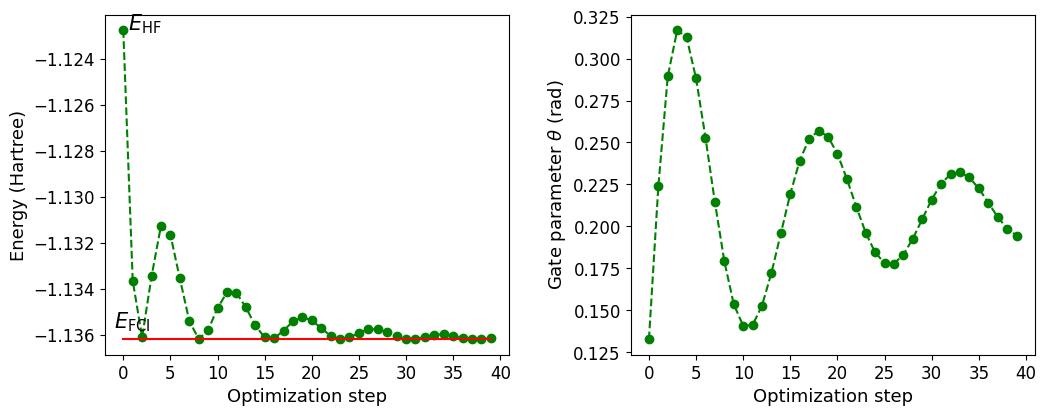

In [115]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

num_data_points = len(results["theta_param"])

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(0, num_data_points), results["energy_expectation_value"], "go", ls="dashed")
ax1.plot(range(0, num_data_points), np.full(num_data_points, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, results["energy_expectation_value"][0], r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(-1, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(0, num_data_points), results["theta_param"], "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()